# Georgia Analysis

This notebook examines the results of the Georgia chain runs, and looks at baseline partisanship in the state as well as baseline minority representation.

## Chain Runs

Each ensemble was run using ReCom for 100,000 steps.  The congressional ensemble was 1\% population balanced (from ideal), the State Senate ensemble 2\%, and the State House ensemble 5\%.

(In the precinct shapefile the balance from ideal for the enacted plans is 1.5\% for the congressional plan, 3.95\% for the state senate, and 29.1\% for the state house.)

### Demographic Stats for GA

// No 2014-18 ACS VAP table

|  .  | 2010 Census TOTPOP  |  2010 Census VAP | 2014-18 ACS TOTPOP | 2014-18 ACS VAP|
|---|---|---|---|---|
| White NH  | 5,413,920 (55.9\%)  | 4,242,514 (59.0\%) | 5,476,441 (53.2\%) |   |
| Black NH  | 2,910,800 (30.0\%)  | 2,072,946 (28.8\%) | 3,195,363 (31.0\%) |   |
| Hispanic  | 853,689 (8.8\%)     | 539,002 (7.5\%)    | 968,463 (9.4\%)    |   |
| Asian     | 311,692 (3.2\%)     | 234,164 (3.3\%)    | 399,223 (3.9\%)    |   |
| Two or more races                           | 151,980 (1.6\%) | 77,345 (1.1\%)  | 204,114 (2.0\%) |   |
| American Indian or Alaskan Native           | 21,279 (0.22\%) | 16,324 (0.23\%) | 18,416 (0.18\%) |   |
| Other races                                 | 19,141 (0.20\%) | 10,107 (0.14\%) | 30,394 (0.30\%) |   |
| Native Hawaiian and Other Pacific Islander  | 5,152  (0.05\%) | 3,699  (0.05\%) | 5,070  (0.05\%) |   |
|---|---|---|---|---|
| TOTAL     | 9,687,653           | 7,196,101          | 10,297,484         |   |


### Elections in GA

| Election | Democratic Share | Republican Share |
|---|---|---|
| PRES16   | 47.33\%          | 52.67\%          |
| SEN16    | 42.82\%          | 57.18\%          |

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import sys
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
import seaborn as sns

## Pull in Statewide data

In [5]:
df = gpd.read_file("GA_precincts16/GA_precincts16.shp")

In [6]:
df.head()

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
0,6094217,1013,073131,131,JOURNEY COMM. CHURCH,Columbia,13073,073,107,459,...,40,3,5,0,0,7,012,122,024,"POLYGON ((-82.14546199999999 33.57854, -82.145..."
1,6094266,3858,073064,064,GRACE BAPTIST CHURCH,Columbia,13073,073,767,1334,...,536,5,120,5,3,32,010,122,024,"POLYGON ((-82.16342400000001 33.574227, -82.16..."
2,6094297,1920,073061,061,GREENBRIER HIGH,Columbia,13073,073,387,1393,...,87,3,31,0,1,9,010,122,024,"POLYGON ((-82.16580999999999 33.564983, -82.16..."
3,6094341,1770,073063,063,RIVERSIDE ELEMENTARY,Columbia,13073,073,267,624,...,145,2,28,0,3,15,012,122,024,"POLYGON ((-82.139089 33.575924, -82.139141 33...."
4,6094377,3131,073132,132,WESLEY METHODIST,Columbia,13073,073,452,1377,...,197,10,109,3,1,21,012,122,024,"POLYGON ((-82.14330200000001 33.573481, -82.14..."


In [7]:
print("PRES16")
print("Dem share: {}".format(sum(df["PRES16D"]) / (sum(df["PRES16D"]) + sum(df["PRES16R"]))))
print("Rep share: {}".format(sum(df["PRES16R"]) / (sum(df["PRES16D"]) + sum(df["PRES16R"]))))

print("\nSEN16")
print("Dem share: {}".format(sum(df["SEN16D"]) / (sum(df["SEN16D"]) + sum(df["SEN16R"]))))
print("Rep share: {}".format(sum(df["SEN16R"]) / (sum(df["SEN16D"]) + sum(df["SEN16R"]))))

PRES16
Dem share: 0.47329979312755993
Rep share: 0.5267002068724401

SEN16
Dem share: 0.4282093525285767
Rep share: 0.5717906474714233


In [8]:
# graph = Graph.from_file("GA_precincts16/GA_precincts16.shp")

In [9]:
with open("GA_graph_3_7_1.p", "rb") as f:
    graph = pickle.load(f)

In [10]:
elections = [Election("SEN16", {"Dem": "SEN16D", "Rep": "SEN16R"}),
             Election("PRES16", {"Dem": "PRES16D", "Rep": "PRES16R"})]


ga_updaters = {"population" : Tally("TOTPOP", alias="population"),
               "cut_edges": cut_edges,
               "VAP": Tally("VAP"),
               "WVAP": Tally("WVAP"),
               "HVAP": Tally("HVAP"),
               "BVAP": Tally("BVAP"),
               "HVAP_perc": lambda p: {k: (v / p["VAP"][k]) for k, v in p["HVAP"].items()},
               "WVAP_perc": lambda p: {k: (v / p["VAP"][k]) for k, v in p["WVAP"].items()},
               "BVAP_perc": lambda p: {k: (v / p["VAP"][k]) for k, v in p["BVAP"].items()},
               "BHVAP_perc": lambda p: {k: ((p["HVAP"][k] + p["BVAP"][k]) / v) for k, v in p["VAP"].items()},}

election_updaters = {election.name: election for election in elections}
ga_updaters.update(election_updaters)

In [11]:
sen_part = Partition(graph, assignment="SENDIST", updaters=ga_updaters)
cong_part = Partition(graph, assignment="CONDIST", updaters=ga_updaters)

In [12]:
df.columns

Index(['ID', 'POPULATION', 'DISTRICT', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'FIPS1', 'FIPS2', 'PRES16D', 'PRES16R', 'PRES16L', 'SEN16D', 'SEN16R',
       'SEN16L', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'CONDIST', 'HDIST', 'SENDIST', 'geometry'],
      dtype='object')

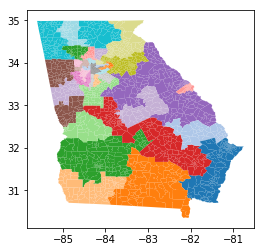

In [14]:
sen_part.plot(cmap="tab20")

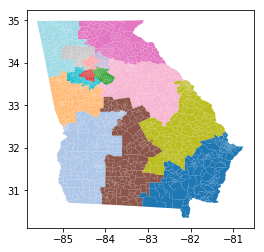

In [15]:
cong_part.plot(cmap="tab20")

## Congress

In [16]:
with open("data/GA_congress_100000.p", "rb") as f:
    cong = pickle.load(f)

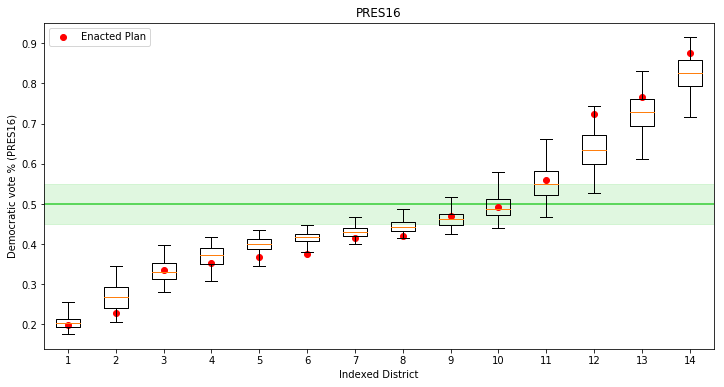

In [18]:
plt.figure(figsize=(12,6))
plt.title("PRES16")
plt.xlabel("Indexed District")
plt.ylabel("Democratic vote % (PRES16)")
plt.boxplot(cong["results_pres16"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(cong_part["PRES16"].percents("Dem")), x=range(1,15), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.45, 0.55, color="limegreen", alpha=0.15, zorder=0)
plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/partisanship/GA_cong_dem_vote_share_pres16.png", bbox_inches="tight", dpi=200)
plt.show()

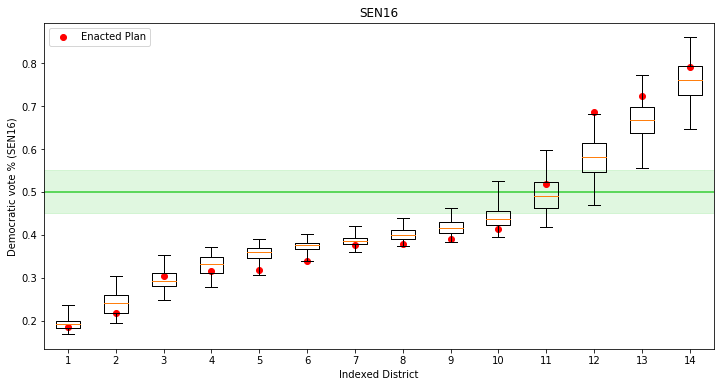

In [19]:
plt.figure(figsize=(12,6))
plt.title("SEN16")
plt.xlabel("Indexed District")
plt.ylabel("Democratic vote % (SEN16)")
plt.boxplot(cong["results_sen16"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(cong_part["SEN16"].percents("Dem")), x=range(1,15), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.45, 0.55, color="limegreen", alpha=0.15, zorder=0)
plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/partisanship/GA_cong_dem_vote_share_sen16.png", bbox_inches="tight", dpi=200)
plt.show()

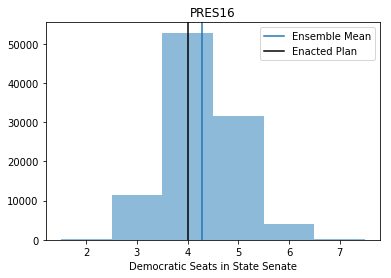

In [20]:
plt.title("PRES16")
plt.xlabel("Democratic Seats in State Senate")
plt.hist(cong["seats_pres16"], histtype="stepfilled", bins=np.arange(2,9)-0.5, alpha=0.5)
plt.axvline(x=np.mean(cong["seats_pres16"]), label="Ensemble Mean")
plt.axvline(x=cong_part["PRES16"].seats("Dem"), label="Enacted Plan", c="k")
plt.legend()
plt.savefig("plots/partisanship/GA_cong_dem_seats_pres16.png", bbox_inches="tight", dpi=200)
plt.show()

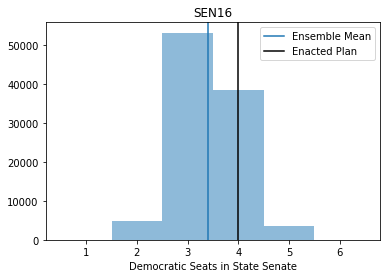

In [21]:
plt.title("SEN16")
plt.xlabel("Democratic Seats in State Senate")
plt.hist(cong["seats_sen16"], histtype="stepfilled", bins=np.arange(1,8)-0.5, alpha=0.5)
plt.axvline(x=np.mean(cong["seats_sen16"]), label="Ensemble Mean")
plt.axvline(x=cong_part["SEN16"].seats("Dem"), label="Enacted Plan", c="k")
plt.legend()
plt.savefig("plots/partisanship/GA_cong_dem_seats_sen16.png", bbox_inches="tight", dpi=200)
plt.show()

In [14]:
cong.keys()

dict_keys(['cutedges', 'HVAP', 'BVAP', 'HVAP_perc', 'BVAP_perc', 'BHVAP_perc', 'WVAP', 'WVAP_perc', 'seats_pres16', 'results_pres16', 'efficiency_gap_pres16', 'mean_median_pres16', 'partisan_gini_pres16', 'seats_sen16', 'results_sen16', 'efficiency_gap_sen16', 'mean_median_sen16', 'partisan_gini_sen16'])

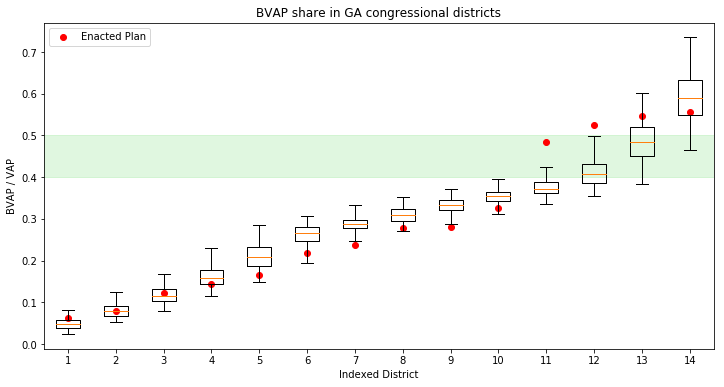

In [22]:
plt.figure(figsize=(12,6))
plt.title("BVAP share in GA congressional districts")
plt.xlabel("Indexed District")
plt.ylabel("BVAP / VAP")
plt.boxplot(cong["BVAP_perc"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(cong_part["BVAP_perc"].values()), x=range(1,15), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
# plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/minority_opportunity/GA_cong_district_bvap.png", bbox_inches="tight", dpi=200)
plt.show()

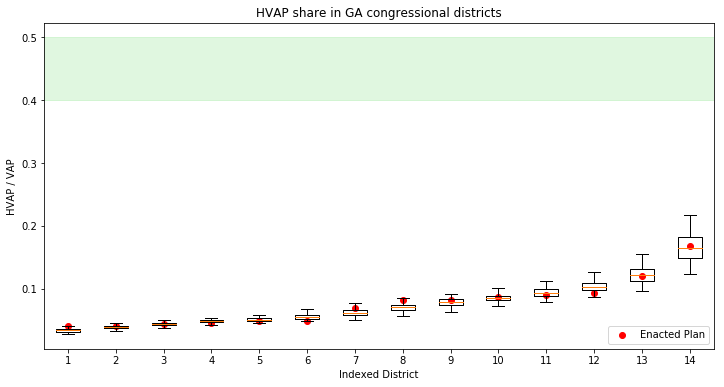

In [23]:
plt.figure(figsize=(12,6))
plt.title("HVAP share in GA congressional districts")
plt.xlabel("Indexed District")
plt.ylabel("HVAP / VAP")
plt.boxplot(cong["HVAP_perc"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(cong_part["HVAP_perc"].values()), x=range(1,15), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
# plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/minority_opportunity/GA_cong_district_hvap.png", bbox_inches="tight", dpi=200)
plt.show()

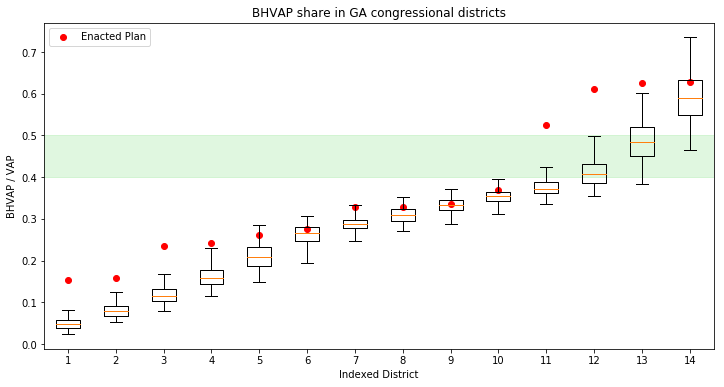

In [24]:
plt.figure(figsize=(12,6))
plt.title("BHVAP share in GA congressional districts")
plt.xlabel("Indexed District")
plt.ylabel("BHVAP / VAP")
plt.boxplot(cong["BVAP_perc"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(cong_part["BHVAP_perc"].values()), x=range(1,15), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
# plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/minority_opportunity/GA_cong_district_bhvap.png", bbox_inches="tight", dpi=200)
plt.show()

## State Senate

In [25]:
with open("data/GA_state_senate_100000.p", "rb") as f:
    sen = pickle.load(f)

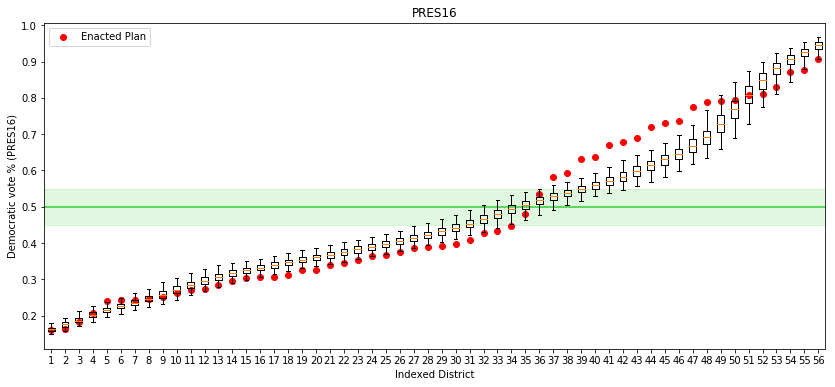

In [26]:
plt.figure(figsize=(14,6))
plt.title("PRES16")
plt.xlabel("Indexed District")
plt.ylabel("Democratic vote % (PRES16)")
plt.boxplot(sen["results_pres16"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(sen_part["PRES16"].percents("Dem")), x=range(1,57), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.45, 0.55, color="limegreen", alpha=0.15, zorder=0)
plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/partisanship/GA_state_senate_dem_vote_share_pres16.png", bbox_inches="tight", dpi=200)
plt.show()

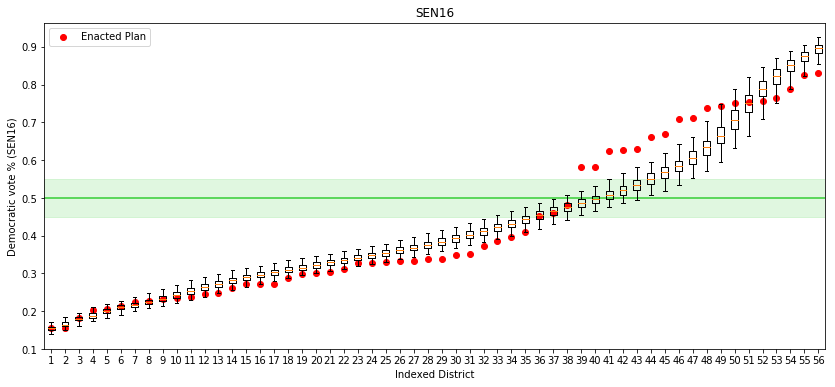

In [27]:
plt.figure(figsize=(14,6))
plt.title("SEN16")
plt.xlabel("Indexed District")
plt.ylabel("Democratic vote % (SEN16)")
plt.boxplot(sen["results_sen16"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(sen_part["SEN16"].percents("Dem")), x=range(1,57), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.45, 0.55, color="limegreen", alpha=0.15, zorder=0)
plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/partisanship/GA_state_senate_dem_vote_share_sen16.png", bbox_inches="tight", dpi=200)
plt.show()

In [21]:
sen.keys()

dict_keys(['cutedges', 'HVAP', 'BVAP', 'HVAP_perc', 'BVAP_perc', 'BHVAP_perc', 'WVAP', 'WVAP_perc', 'seats_pres16', 'results_pres16', 'efficiency_gap_pres16', 'mean_median_pres16', 'partisan_gini_pres16', 'seats_sen16', 'results_sen16', 'efficiency_gap_sen16', 'mean_median_sen16', 'partisan_gini_sen16'])

In [22]:
min(sen["seats_sen16"])

11.0

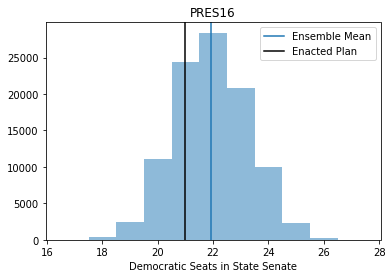

In [28]:
plt.title("PRES16")
plt.xlabel("Democratic Seats in State Senate")
plt.hist(sen["seats_pres16"], histtype="stepfilled", bins=np.arange(17,29)-0.5, alpha=0.5)
plt.axvline(x=np.mean(sen["seats_pres16"]), label="Ensemble Mean")
plt.axvline(x=sen_part["PRES16"].seats("Dem"), label="Enacted Plan", c="k")
plt.legend()
plt.savefig("plots/partisanship/GA_state_senate_dem_seats_pres16.png", bbox_inches="tight", dpi=200)
plt.show()

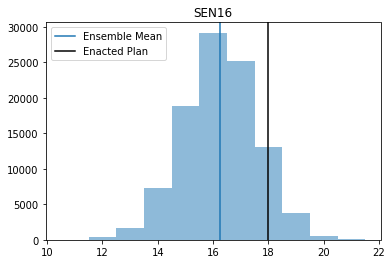

In [29]:
plt.title("SEN16")
plt.hist(sen["seats_sen16"], histtype="stepfilled", bins=np.arange(11,23)-0.5, alpha=0.5)
plt.axvline(x=np.mean(sen["seats_sen16"]), label="Ensemble Mean")
plt.axvline(x=sen_part["SEN16"].seats("Dem"), label="Enacted Plan", c="k")
plt.legend()
plt.savefig("plots/partisanship/GA_state_senate_dem_seats_sen16.png", bbox_inches="tight", dpi=200)
plt.show()

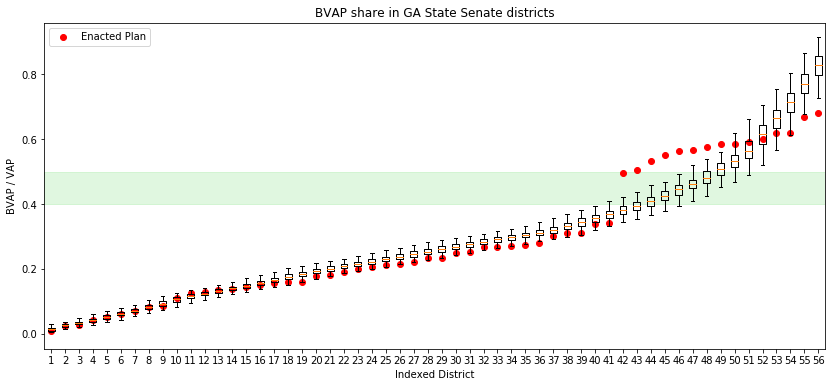

In [30]:
plt.figure(figsize=(14,6))
plt.title("BVAP share in GA State Senate districts")
plt.xlabel("Indexed District")
plt.ylabel("BVAP / VAP")
plt.boxplot(sen["BVAP_perc"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(sen_part["BVAP_perc"].values()), x=range(1,57), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
# plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/minority_opportunity/GA_state_senate_district_bvap.png", bbox_inches="tight", dpi=200)
plt.show()

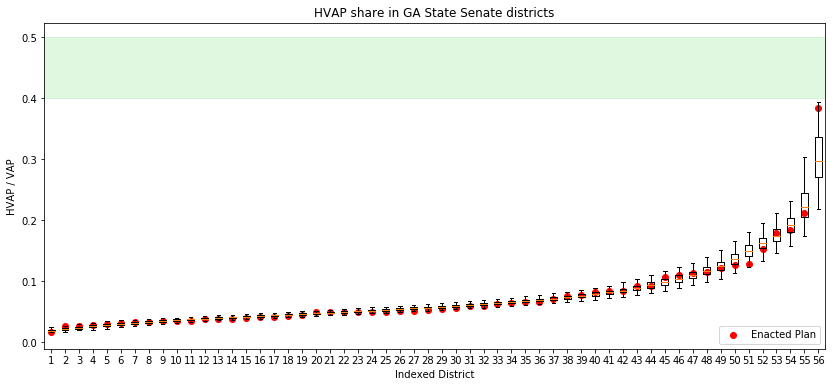

In [31]:
plt.figure(figsize=(14,6))
plt.title("HVAP share in GA State Senate districts")
plt.xlabel("Indexed District")
plt.ylabel("HVAP / VAP")
plt.boxplot(sen["HVAP_perc"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(sen_part["HVAP_perc"].values()), x=range(1,57), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
# plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/minority_opportunity/GA_state_senate_district_hvap.png", bbox_inches="tight", dpi=200)
plt.show()

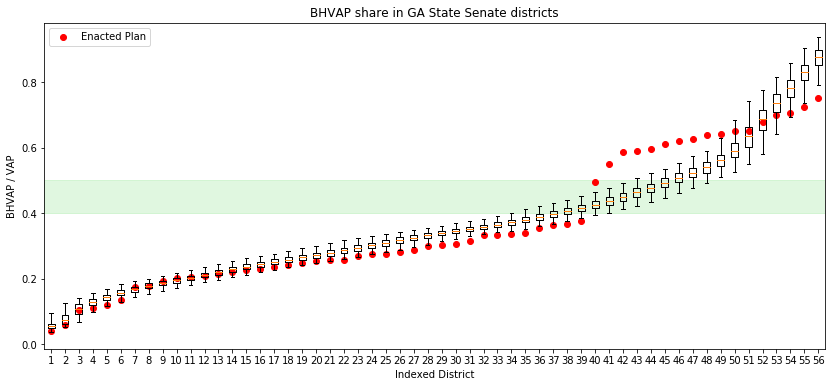

In [32]:
plt.figure(figsize=(14,6))
plt.title("BHVAP share in GA State Senate districts")
plt.xlabel("Indexed District")
plt.ylabel("BHVAP / VAP")
plt.boxplot(sen["BHVAP_perc"], whis=(1,99), showfliers=False)
plt.scatter(y=sorted(sen_part["BHVAP_perc"].values()), x=range(1,57), 
            marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)
# plt.axhline(y=0.5, color="limegreen", zorder=0)
plt.legend()
plt.savefig("plots/minority_opportunity/GA_state_senate_district_bhvap.png", bbox_inches="tight", dpi=200)
plt.show()

## State House

In [34]:
with open("/cluster/tufts/mggg/jmatth03/Georgia/GA_state_house_100000.p", "rb") as f:
    house = pickle.load(f)

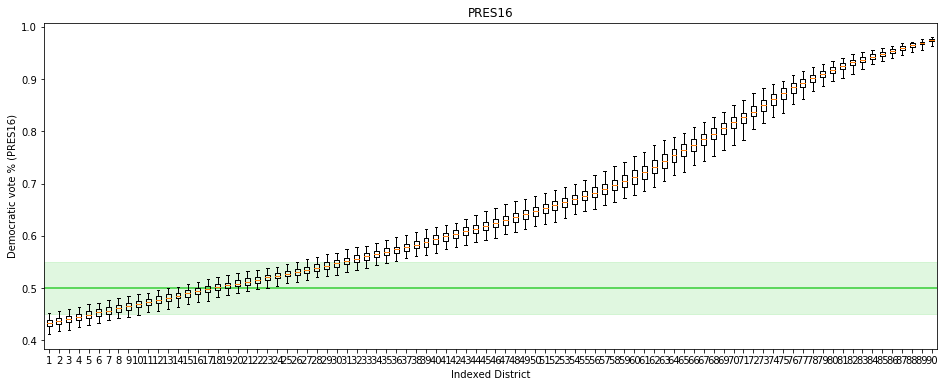

In [35]:
plt.figure(figsize=(16,6))
plt.title("PRES16")
plt.xlabel("Indexed District")
plt.ylabel("Democratic vote % (PRES16)")
plt.boxplot(house["results_pres16"][:, 90:], whis=(1,99), showfliers=False)
# plt.scatter(y=sorted(sen_part["PRES16"].percents("Dem")), x=range(1,57), 
#             marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.45, 0.55, color="limegreen", alpha=0.15, zorder=0)
plt.axhline(y=0.5, color="limegreen", zorder=0)
# plt.legend()
plt.savefig("plots/partisanship/GA_state_house_dem_vote_share_pres16.png", bbox_inches="tight", dpi=200)
plt.show()

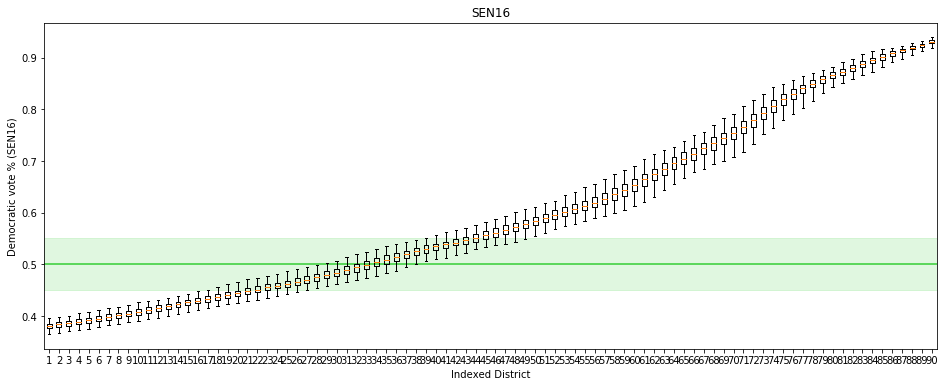

In [36]:
plt.figure(figsize=(16,6))
plt.title("SEN16")
plt.xlabel("Indexed District")
plt.ylabel("Democratic vote % (SEN16)")
plt.boxplot(house["results_sen16"][:, 90:], whis=(1,99), showfliers=False)
# plt.scatter(y=sorted(sen_part["SEN16"].percents("Dem")), x=range(1,57), 
#             marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.45, 0.55, color="limegreen", alpha=0.15, zorder=0)
plt.axhline(y=0.5, color="limegreen", zorder=0)
# plt.legend()
plt.savefig("plots/partisanship/GA_state_house_dem_vote_share_sen16.png", bbox_inches="tight", dpi=200)
plt.show()

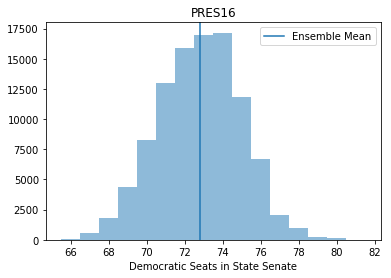

In [37]:
plt.title("PRES16")
plt.xlabel("Democratic Seats in State Senate")
plt.hist(house["seats_pres16"], histtype="stepfilled", bins=np.arange(66,83)-0.5, alpha=0.5)
plt.axvline(x=np.mean(house["seats_pres16"]), label="Ensemble Mean")
# plt.axvline(x=house_part["PRES16"].seats("Dem"), label="Enacted Plan", c="k")
plt.legend()
plt.savefig("plots/partisanship/GA_state_house_dem_seats_pres16.png", bbox_inches="tight", dpi=200)
plt.show()

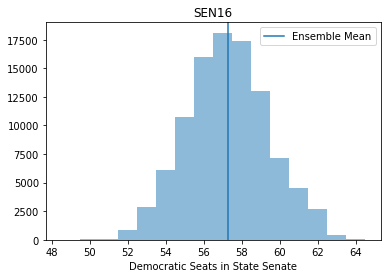

In [38]:
plt.title("SEN16")
plt.xlabel("Democratic Seats in State Senate")
plt.hist(house["seats_sen16"], histtype="stepfilled", bins=np.arange(49,66)-0.5, alpha=0.5)
plt.axvline(x=np.mean(house["seats_sen16"]), label="Ensemble Mean")
# plt.axvline(x=house_part["PRES16"].seats("Dem"), label="Enacted Plan", c="k")
plt.legend()
plt.savefig("plots/partisanship/GA_state_house_dem_seats_sen16.png", bbox_inches="tight", dpi=200)
plt.show()

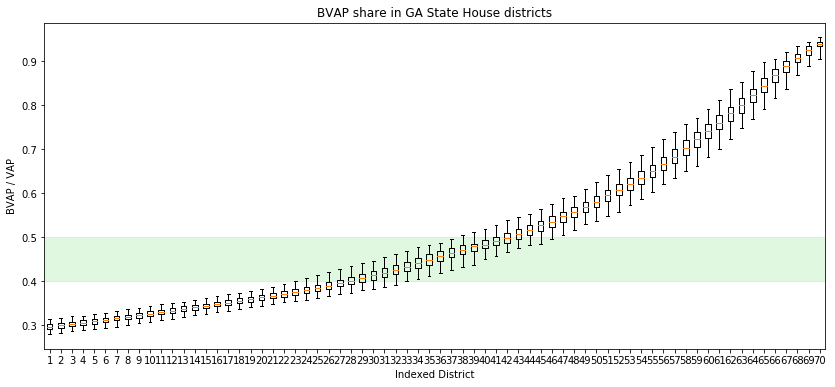

In [39]:
plt.figure(figsize=(14,6))
plt.title("BVAP share in GA State House districts")
plt.xlabel("Indexed District")
plt.ylabel("BVAP / VAP")
plt.boxplot(house["BVAP_perc"][:, 110:], whis=(1,99), showfliers=False)
# plt.scatter(y=sorted(sen_part["BVAP_perc"].values()), x=range(1,57), 
#             marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)

# plt.legend()
plt.savefig("plots/minority_opportunity/GA_state_house_district_bvap.png", bbox_inches="tight", dpi=200)
plt.show()

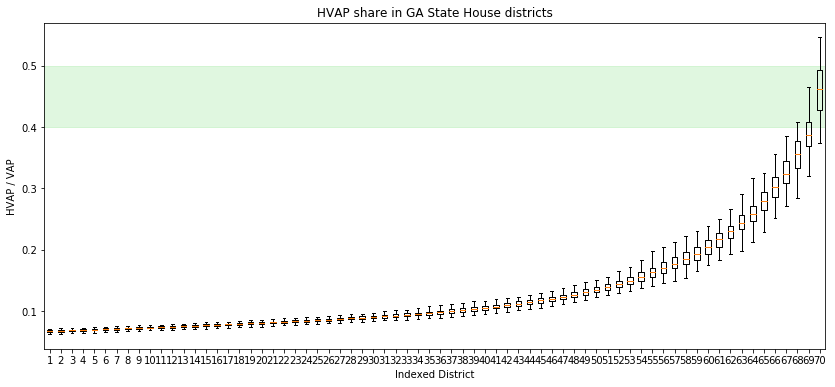

In [40]:
plt.figure(figsize=(14,6))
plt.title("HVAP share in GA State House districts")
plt.xlabel("Indexed District")
plt.ylabel("HVAP / VAP")
plt.boxplot(house["HVAP_perc"][:, 110:], whis=(1,99), showfliers=False)
# plt.scatter(y=sorted(sen_part["BVAP_perc"].values()), x=range(1,57), 
#             marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)

# plt.legend()
plt.savefig("plots/minority_opportunity/GA_state_house_district_hvap.png", bbox_inches="tight", dpi=200)
plt.show()

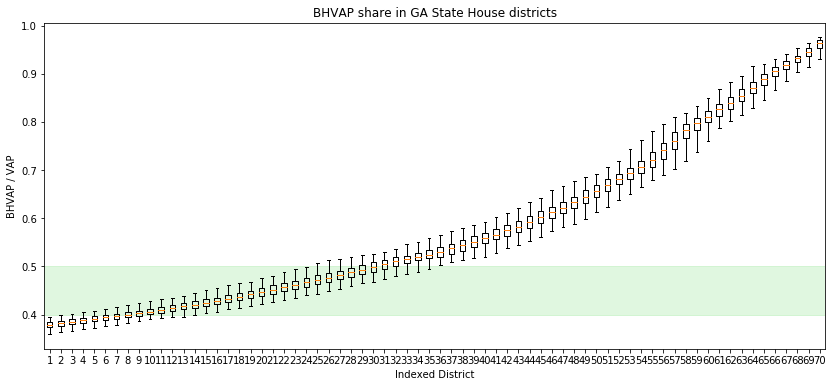

In [41]:
plt.figure(figsize=(14,6))
plt.title("BHVAP share in GA State House districts")
plt.xlabel("Indexed District")
plt.ylabel("BHVAP / VAP")
plt.boxplot(house["BHVAP_perc"][:, 110:], whis=(1,99), showfliers=False)
# plt.scatter(y=sorted(sen_part["BVAP_perc"].values()), x=range(1,57), 
#             marker="o", label="Enacted Plan", c="r")
plt.axhspan(0.40, 0.50, color="limegreen", alpha=0.15, zorder=0)

# plt.legend()
plt.savefig("plots/minority_opportunity/GA_state_house_district_bhvap.png", bbox_inches="tight", dpi=200)
plt.show()

## Partisanship

In [42]:
def extend_data_frame(df, data, key_prefix, col, districts,
                      elections=["PRES16", "SEN16"], iters=100000):
    for elect in elections:
        key = key_prefix.format(elect.lower())
        df = pd.concat([df, pd.DataFrame(np.array([data[key], [elect]*iters, [districts]*iters]).T,
                                         columns=[col, "Election", "Districts"])], ignore_index=True)
    return df

In [43]:
elections = ["PRES16", "SEN16"]

In [44]:
eg = pd.DataFrame()
eg = extend_data_frame(eg, cong, "efficiency_gap_{}", "EG", 14, elections=elections)
eg = extend_data_frame(eg, sen, "efficiency_gap_{}", "EG", 56, elections=elections)
eg = extend_data_frame(eg, house, "efficiency_gap_{}", "EG", 180, elections=elections)

eg["EG"] = eg["EG"].apply(float)
eg["Districts"] = eg["Districts"].apply(int)

In [45]:
mm = pd.DataFrame()
mm = extend_data_frame(mm, cong, "mean_median_{}", "MM", 14, elections=elections)
mm = extend_data_frame(mm, sen, "mean_median_{}", "MM", 56, elections=elections)
mm = extend_data_frame(mm, house, "mean_median_{}", "MM", 180, elections=elections)

mm["MM"] = mm["MM"].apply(float)
mm["Districts"] = mm["Districts"].apply(int)

In [46]:
pg = pd.DataFrame()
pg = extend_data_frame(pg, cong, "partisan_gini_{}", "PG", 14, elections=elections)
pg = extend_data_frame(pg, sen, "partisan_gini_{}", "PG", 56, elections=elections)
pg = extend_data_frame(pg, house, "partisan_gini_{}", "PG", 180, elections=elections)

pg["PG"] = pg["PG"].apply(float)
pg["Districts"] = pg["Districts"].apply(int)

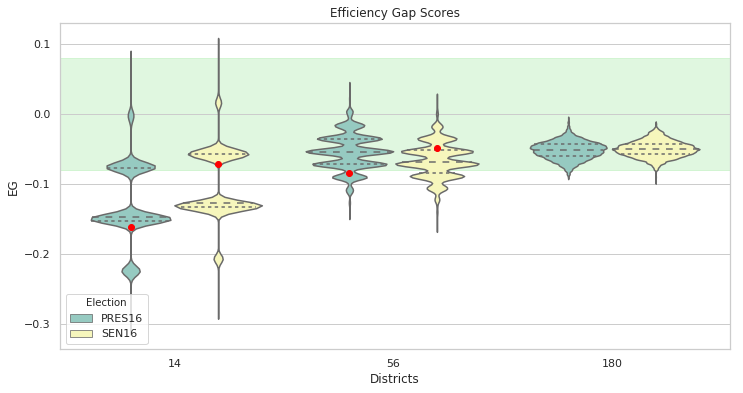

In [47]:
sns.set(style="whitegrid", palette="Set3")
es = ["PRES16", "SEN16"]
plt.figure(figsize=(12,6))
plt.title("Efficiency Gap Scores")
sns.violinplot(x="Districts", y="EG", hue="Election", hue_order=es, 
               data=eg, inner="quartile")
plt.axhspan(-0.08, 0.08, color="limegreen", alpha=0.15, zorder=0)

for i in [-1,1]:
    plt.plot([0 + i*0.2],cong_part[es[int(i == 1)]].efficiency_gap(), marker="o", color="red")
    plt.plot([1 + i*0.2],sen_part[es[int(i == 1)]].efficiency_gap(), marker="o", color="red")
#     plt.plot([3 + i*0.270],house[es[i+1]].efficiency_gap(), marker="o", color="red")
plt.savefig("plots/partisanship/effiency_gap_scores.png", bbox_inches="tight", dpi=200)
plt.show()

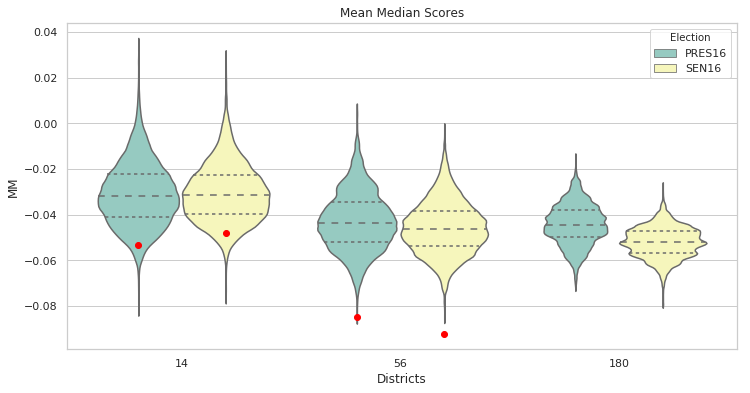

In [48]:
sns.set(style="whitegrid", palette="Set3")
es = ["PRES16", "SEN16"]
plt.figure(figsize=(12,6))
plt.title("Mean Median Scores")
sns.violinplot(x="Districts", y="MM", hue="Election", hue_order=es, 
               data=mm, inner="quartile")

for i in [-1,1]:
    plt.plot([0 + i*0.2],cong_part[es[int(i == 1)]].mean_median(), marker="o", color="red")
    plt.plot([1 + i*0.2],sen_part[es[int(i == 1)]].mean_median(), marker="o", color="red")

plt.savefig("plots/partisanship/mean_median_scores.png", bbox_inches="tight", dpi=200)
plt.show()

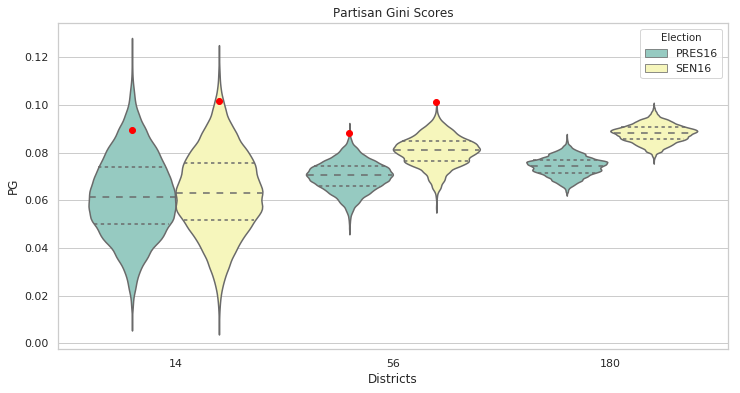

In [49]:
sns.set(style="whitegrid", palette="Set3")
es = ["PRES16", "SEN16"]
plt.figure(figsize=(12,6))
plt.title("Partisan Gini Scores")
sns.violinplot(x="Districts", y="PG", hue="Election", hue_order=es, 
               data=pg, inner="quartile")

for i in [-1,1]:
    plt.plot([0 + i*0.2],cong_part[es[int(i == 1)]].partisan_gini(), marker="o", color="red")
    plt.plot([1 + i*0.2],sen_part[es[int(i == 1)]].partisan_gini(), marker="o", color="red")
    
plt.savefig("plots/partisanship/partisan_gini_scores.png", bbox_inches="tight", dpi=200)
plt.show()